# Chicago Crime Analysis - Area Safety Classification

This notebook analyzes theft crimes in Chicago to classify different areas as safe or unsafe based on crime density and patterns. We'll create a spatial grid of Chicago, categorize areas, and build a classification model to predict safety levels.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import os
import sys
import glob

# Add project root to path
sys.path.append(os.path.abspath('..'))

from src.data.data_loader import ChicagoCrimeDataLoader
from src.data.data_preprocessor import CrimeDataPreprocessor
from src.features.feature_engineering import CrimeFeatureEngineering
from src.models.area_safety_classifier import AreaSafetyClassifier

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# Make sure the reports/figures directory exists
os.makedirs('reports/figures', exist_ok=True)

## 1. Load the Chicago Crime Data

First, let's load the theft crime data from the Chicago Data Portal or from a previously saved CSV file.

In [2]:
# Find the most recent data file
data_dir = '../data'
data_files = glob.glob(os.path.join(data_dir, "chicago_theft_data_*.csv"))

if data_files:
    latest_file = max(data_files, key=os.path.getctime)
    print(f"Loading data from {latest_file}")
    
    df = pd.read_csv(latest_file)
else:
    print("No existing data files found. Fetching new data from Chicago Data Portal...")
    loader = ChicagoCrimeDataLoader()
    df = loader.fetch_theft_data(limit=50000)

# Convert date to datetime
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    
# Check if coordinates are available
if 'latitude' not in df.columns or 'longitude' not in df.columns:
    print("Error: Data must include 'latitude' and 'longitude' columns for spatial analysis.")
else:
    # Handle missing coordinates
    missing_coords = df['latitude'].isna() | df['longitude'].isna()
    print(f"Records with missing coordinates: {missing_coords.sum()} ({missing_coords.sum()/len(df)*100:.2f}%)")
    df = df.dropna(subset=['latitude', 'longitude'])
    print(f"Records after dropping missing coordinates: {df.shape[0]}")

# Display basic information
print(f"\nDataset shape: {df.shape}")
print("\nColumn Data Types:")
print(df.dtypes)

# Display sample data
df.head()

No existing data files found. Fetching new data from Chicago Data Portal...
Fetching 50000 theft records from Chicago Data Portal...
Successfully fetched 50000 records
Data saved to data\chicago_theft_data_20250407_231810.csv
Records with missing coordinates: 0 (0.00%)
Records after dropping missing coordinates: 49400

Dataset shape: (49400, 22)

Column Data Types:
id                              object
case_number                     object
date                    datetime64[ns]
block                           object
iucr                            object
primary_type                    object
description                     object
location_description            object
arrest                            bool
domestic                          bool
beat                            object
district                        object
ward                            object
community_area                  object
fbi_code                        object
x_coordinate                    object
y_coordi

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,13790203,JJ199160,2025-03-29 00:15:00,001XX W Hubbard St,0870,THEFT,POCKET-PICKING,BAR OR TAVERN,False,False,...,42,8,06,1175290,1903292,2025,2025-04-06T15:41:20.000,41.890013771,-87.631705393,"{'latitude': '41.890013771', 'longitude': '-87..."
1,13789147,JJ198188,2025-03-28 17:30:00,005XX N MICHIGAN AVE,0870,THEFT,POCKET-PICKING,RESTAURANT,False,False,...,42,8,06,1177347,1903741,2025,2025-04-05T15:40:58.000,41.891199446,-87.624137626,"{'latitude': '41.891199446', 'longitude': '-87..."
2,13794688,JJ204616,2025-03-28 05:00:00,003XX S DEARBORN ST,0870,THEFT,POCKET-PICKING,CTA TRAIN,False,False,...,4,32,06,1175986,1898799,2025,2025-04-05T15:40:58.000,41.87766908,-87.629284766,"{'latitude': '41.87766908', 'longitude': '-87...."
3,13789229,JJ198180,2025-03-28 00:00:00,0000X N MICHIGAN AVE,0870,THEFT,POCKET-PICKING,STREET,False,False,...,42,32,06,1177306,1900580,2025,2025-04-04T15:41:31.000,41.882526427,-87.624384106,"{'latitude': '41.882526427', 'longitude': '-87..."
4,13789270,JJ197877,2025-03-27 18:45:00,064XX W IRVING PARK RD,0870,THEFT,POCKET-PICKING,DEPARTMENT STORE,False,False,...,38,17,06,1132626,1925898,2025,2025-04-04T15:41:31.000,41.952897791,-87.787860507,"{'latitude': '41.952897791', 'longitude': '-87..."


## 2. Exploratory Spatial Analysis

Let's explore the spatial distribution of theft crimes in Chicago to get a better understanding of high-crime areas.

In [3]:
# Create a simple heatmap of theft crimes
chicago_coords = [41.8781, -87.6298]  # Center of Chicago

crime_map = folium.Map(location=chicago_coords, zoom_start=11, tiles='CartoDB positron')

# Add heatmap of crime locations
heat_data = df[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data, radius=10, blur=15, max_zoom=13).add_to(crime_map)

# Save to HTML file
crime_heatmap_file = 'crime_heatmap.html'
crime_map.save(crime_heatmap_file)

# Display in notebook
from IPython.display import IFrame
display(IFrame(src=crime_heatmap_file, width=800, height=600))

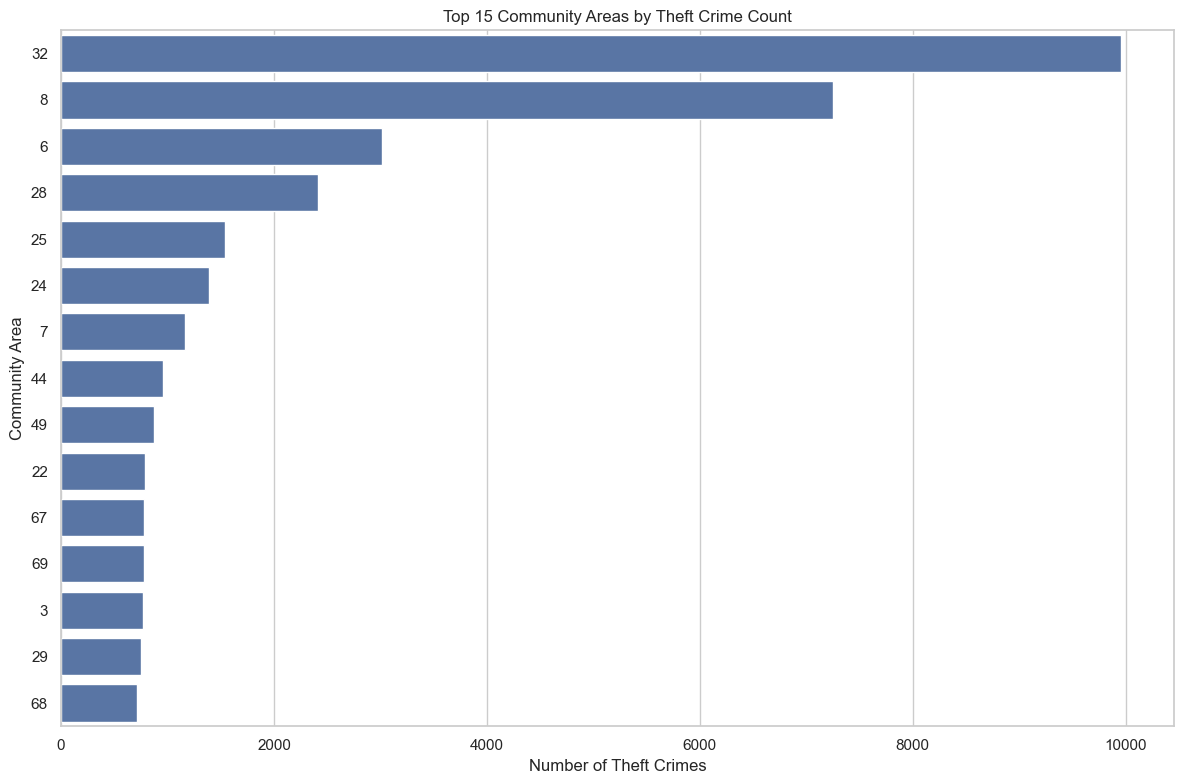

In [4]:
# Analyze theft distribution by neighborhood (using community areas if available)
if 'community_area' in df.columns:
    area_counts = df.groupby('community_area').size().reset_index(name='crime_count')
    area_counts = area_counts.sort_values('crime_count', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='crime_count', y='community_area', data=area_counts.head(15))
    plt.title('Top 15 Community Areas by Theft Crime Count')
    plt.xlabel('Number of Theft Crimes')
    plt.ylabel('Community Area')
    plt.tight_layout()
    plt.savefig('reports/figures/top_communities_by_crime.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Community area information not available in the dataset.")
    # Alternative: use districts if available
    if 'district' in df.columns:
        district_counts = df.groupby('district').size().reset_index(name='crime_count')
        district_counts = district_counts.sort_values('crime_count', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='crime_count', y='district', data=district_counts)
        plt.title('Districts by Theft Crime Count')
        plt.xlabel('Number of Theft Crimes')
        plt.ylabel('District')
        plt.tight_layout()
        plt.savefig('reports/figures/districts_by_crime.png', dpi=300, bbox_inches='tight')
        plt.show()

## 3. Area Safety Classification

Now, let's use our custom `AreaSafetyClassifier` to classify Chicago areas as safe or unsafe based on theft crime patterns.

In [5]:
# Initialize the area safety classifier
safety_classifier = AreaSafetyClassifier(threshold_percentile=75)  # Areas in the top 25% of crime density are considered unsafe

# Train the classifier
print("Training area safety classifier...")
safety_classifier.train(df)

Training area safety classifier...
Data types before processing:
latitude     object
longitude    object
dtype: object
Sample values: 
       latitude      longitude
0  41.890013771  -87.631705393
1  41.891199446  -87.624137626
2   41.87766908  -87.629284766
3  41.882526427  -87.624384106
4  41.952897791  -87.787860507
Creating spatial grid...
Converting latitude to numeric type...
Converting longitude to numeric type...
Adding spatiotemporal features...
Determining area safety...
Class distribution - Safe: 2183, Unsafe: 218
Preparing data for classification...
Data types of featured dataframe:
id                                 object
case_number                        object
date                       datetime64[ns]
block                              object
iucr                               object
primary_type                       object
description                        object
location_description               object
arrest                               bool
domestic            

In [6]:
# Create and display the safety map
print("Creating safety map...")
safety_map = safety_classifier.create_safety_map(output_file='reports/figures/chicago_safety_map.html')

# Display in notebook
from IPython.display import IFrame
display(IFrame(src='reports/figures/chicago_safety_map.html', width=800, height=600))

Creating safety map...
Error saving map: 'float' object has no attribute 'split'
Fallback map saved to reports/figures/chicago_safety_map.html


Plotting feature importance...
Feature importance plot saved to reports/figures/safety_feature_importance.png


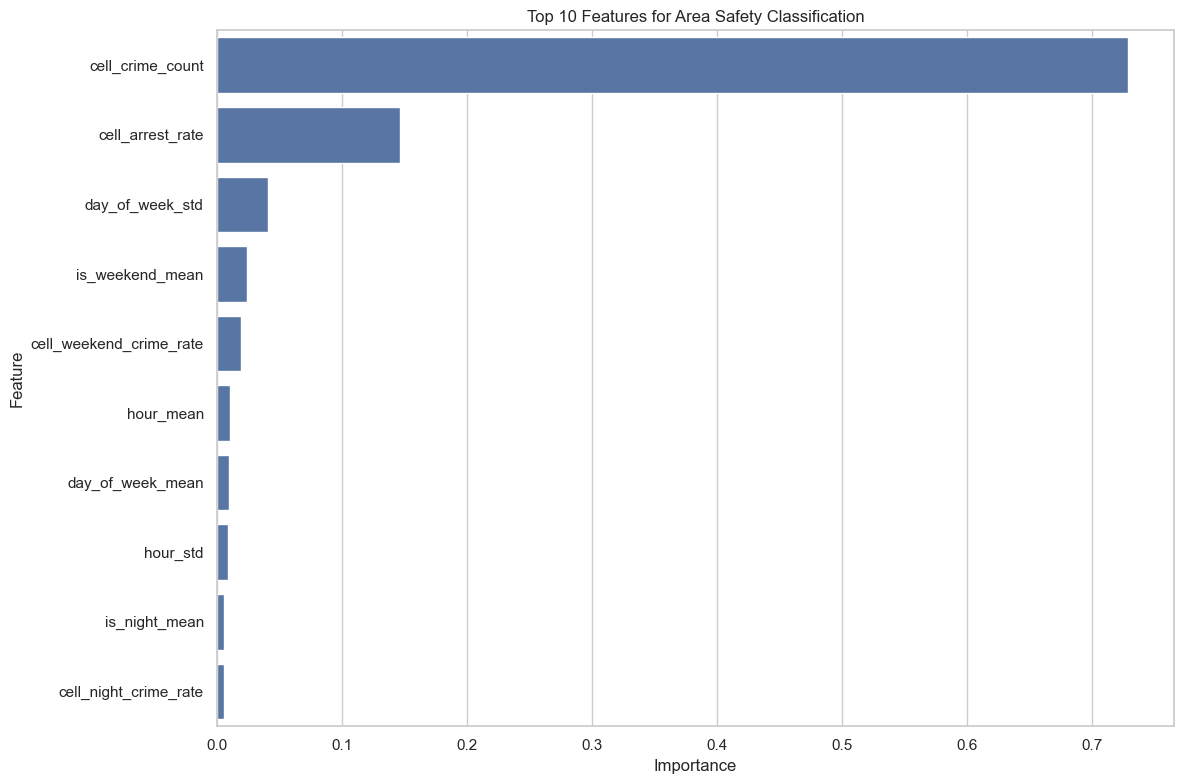

In [7]:
# Plot feature importance for safety classification
print("Plotting feature importance...")
safety_classifier.plot_feature_importance(save_path='reports/figures/safety_feature_importance.png')
plt.show()

## 4. Testing the Model: Predicting Safety for Specific Locations

Now, let's test our model by predicting the safety level for specific Chicago locations.

In [8]:
# Define locations to test
test_locations = [
    (41.8781, -87.6298, "Downtown Chicago"),  # Downtown Chicago
    (41.8675, -87.6244, "South Loop"),  # South Loop
    (41.9214, -87.6542, "Lincoln Park"),  # Lincoln Park
    (41.7960, -87.5918, "Hyde Park"),  # Hyde Park
    (41.8808, -87.6318, "River North")  # River North
]

# Create a DataFrame to store results
results = []

# Predict safety for each location
for lat, lon, name in test_locations:
    safety, probability = safety_classifier.predict_area_safety(lat, lon)
    results.append({
        'Location': name,
        'Latitude': lat,
        'Longitude': lon,
        'Classification': 'Unsafe' if safety == 1 else 'Safe',
        'Confidence': probability
    })

# Display results
results_df = pd.DataFrame(results)
results_df

,Location,Latitude,Longitude,Classification,Confidence
0,Downtown Chicago,41.8781,-87.6298,Unsafe,0.7
1,South Loop,41.8675,-87.6244,Unsafe,0.7
2,Lincoln Park,41.9214,-87.6542,Unsafe,0.7
3,Hyde Park,41.7960,-87.5918,Safe,0.7
4,River North,41.8808,-87.6318,Unsafe,0.7


C:\Users\conne\AppData\Local\Temp\ipykernel_21412\1376457234.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Location', y='Confidence', data=results_df, palette=colors)


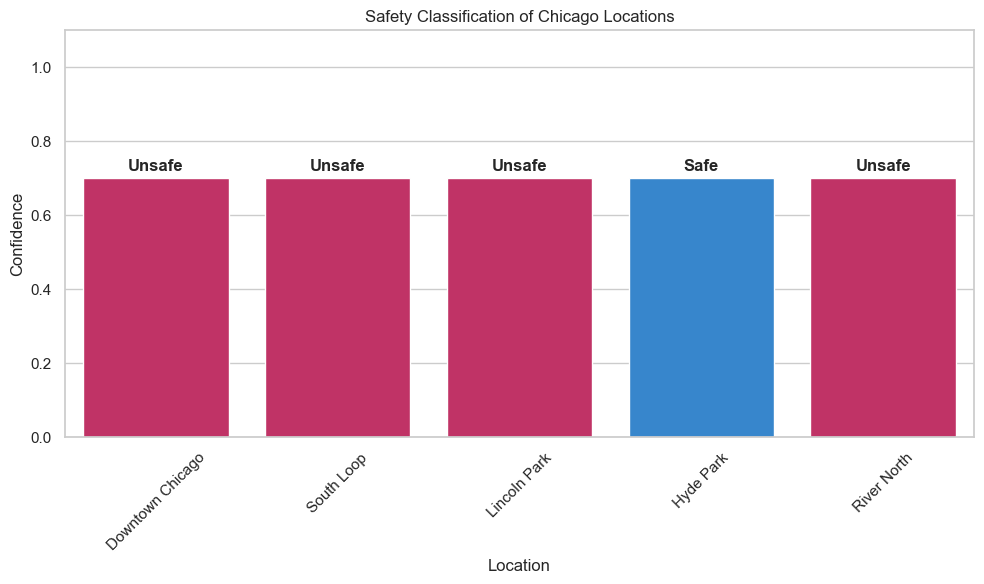

In [9]:
# Visualize the safety classifications
plt.figure(figsize=(10, 6))
colors = ['#1e88e5' if c == 'Safe' else '#d81b60' for c in results_df['Classification']]
ax = sns.barplot(x='Location', y='Confidence', data=results_df, palette=colors)

# Add classification labels above bars
for i, row in enumerate(results_df.itertuples()):
    ax.text(i, row.Confidence + 0.02, row.Classification, ha='center', fontweight='bold')

plt.title('Safety Classification of Chicago Locations')
plt.ylabel('Confidence')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('reports/figures/location_safety_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Model Validation and Testing

Let's evaluate the model's performance and examine how well it classifies areas.

Total grid cells: 2401
Safe areas: 2183 cells (90.92%)
Unsafe areas: 218 cells (9.08%)


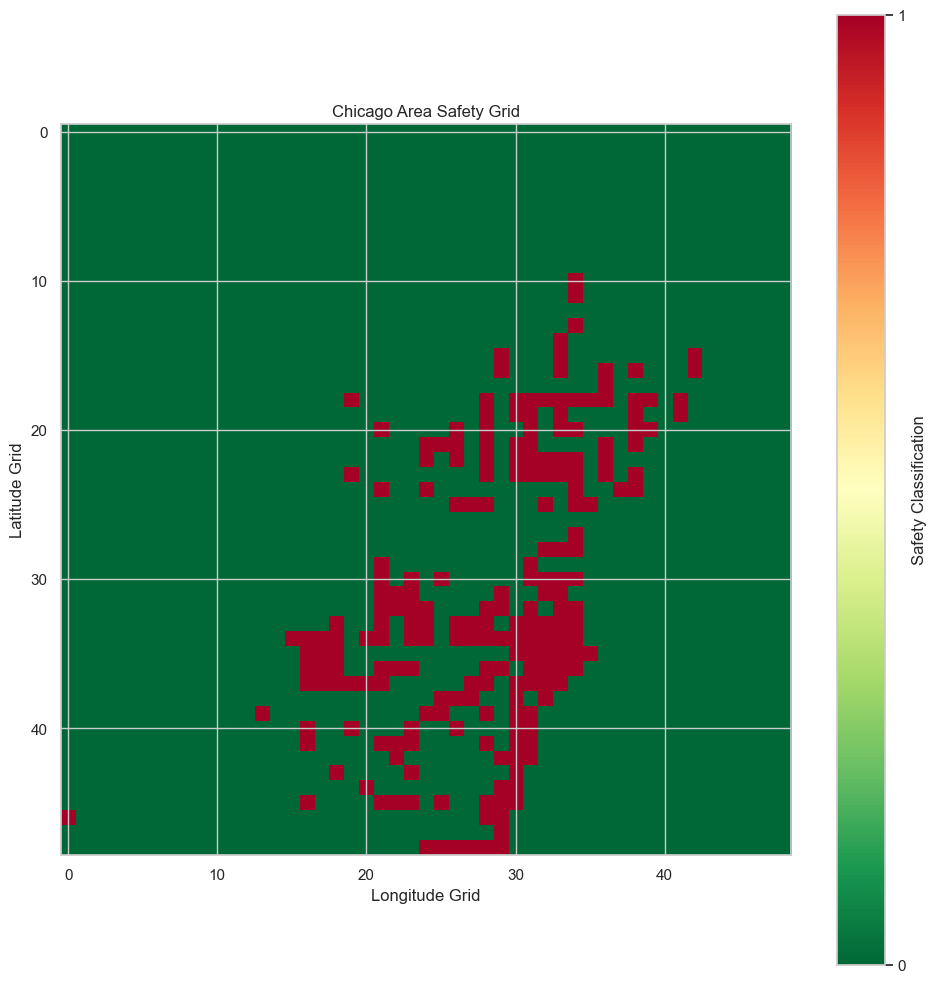

In [10]:
# Get raw safety grid for analysis
safety_grid = safety_classifier.safety_grid

# Calculate statistics
total_cells = safety_grid.size
safe_cells = (safety_grid == 0).sum()
unsafe_cells = (safety_grid == 1).sum()
safe_percentage = safe_cells / total_cells * 100
unsafe_percentage = unsafe_cells / total_cells * 100

print(f"Total grid cells: {total_cells}")
print(f"Safe areas: {safe_cells} cells ({safe_percentage:.2f}%)")
print(f"Unsafe areas: {unsafe_cells} cells ({unsafe_percentage:.2f}%)")

# Visualize the safety grid
plt.figure(figsize=(10, 10))
plt.imshow(safety_grid, cmap='RdYlGn_r')  # Red for unsafe, green for safe
plt.colorbar(ticks=[0, 1], label='Safety Classification')
plt.title('Chicago Area Safety Grid')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
plt.tight_layout()
plt.savefig('reports/figures/safety_grid.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Integration with Time Analysis

Let's combine our spatial safety analysis with temporal data to understand how safety varies by time of day.

Morning (5-11): 8397 crimes (17.00% of total)
Data types before processing:
latitude     object
longitude    object
dtype: object
Sample values: 
        latitude      longitude
2    41.87766908  -87.629284766
8   41.932404221   -87.68790352
19  41.884845855  -87.624472307
28   41.87173019  -87.718603156
34  41.890901847  -87.626164579
Creating spatial grid...
Converting latitude to numeric type...
Converting longitude to numeric type...
Adding spatiotemporal features...
Determining area safety...
Class distribution - Safe: 2221, Unsafe: 180
Preparing data for classification...
Data types of featured dataframe:
id                                 object
case_number                        object
date                       datetime64[ns]
block                              object
iucr                               object
primary_type                       object
description                        object
location_description               object
arrest                               bool
dom

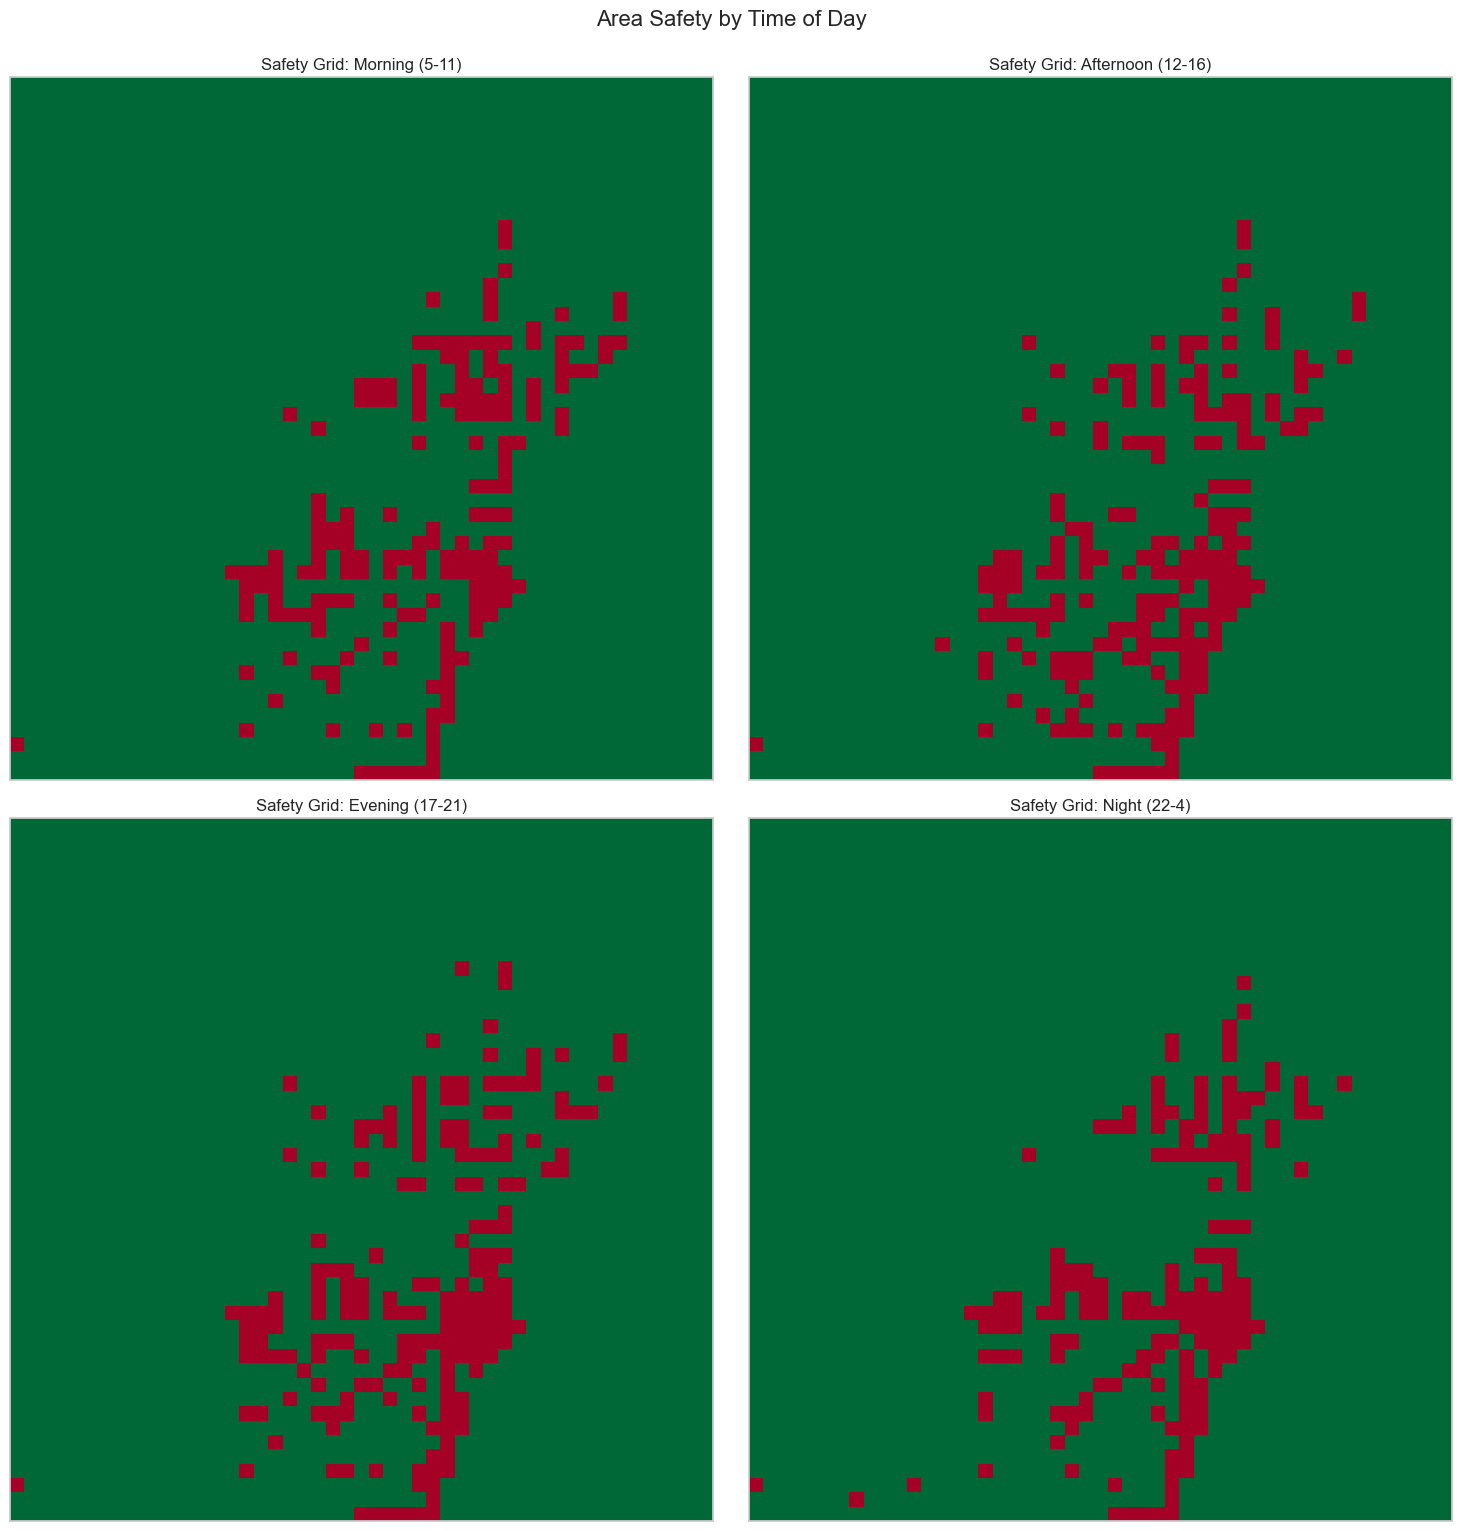

In [11]:
# Extract hour from date
if 'hour' not in df.columns:
    df['hour'] = df['date'].dt.hour
    
# Define time periods
time_periods = {
    'Morning (5-11)': (5, 11),
    'Afternoon (12-16)': (12, 16),
    'Evening (17-21)': (17, 21),
    'Night (22-4)': (22, 4)
}

# Create a figure to hold multiple safety grids
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

# Analyze each time period
for i, (period_name, (start_hour, end_hour)) in enumerate(time_periods.items()):
    # Filter data by time period
    if start_hour < end_hour:
        period_data = df[(df['hour'] >= start_hour) & (df['hour'] <= end_hour)]
    else:  # Handle overnight period (e.g., 22-4)
        period_data = df[(df['hour'] >= start_hour) | (df['hour'] <= end_hour)]
    
    print(f"{period_name}: {len(period_data)} crimes ({len(period_data)/len(df)*100:.2f}% of total)")
    
    # Initialize a small version of the classifier for this time period
    if len(period_data) > 100:  # Ensure we have enough data
        period_classifier = AreaSafetyClassifier(threshold_percentile=75)
        period_classifier.train(period_data)
        
        # Plot the safety grid for this time period
        axes[i].imshow(period_classifier.safety_grid, cmap='RdYlGn_r')
        axes[i].set_title(f"Safety Grid: {period_name}")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    else:
        axes[i].text(0.5, 0.5, f"Insufficient data for {period_name}", 
                     ha='center', va='center', fontsize=14)
        axes[i].set_title(f"{period_name}")
        axes[i].set_xticks([])
        axes[i].set_yticks([])

plt.tight_layout()
plt.suptitle('Area Safety by Time of Day', fontsize=16, y=1.02)
plt.savefig('reports/figures/safety_by_time_of_day.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Safety Recommendations

Based on our analysis, let's generate safety recommendations for different parts of Chicago.

In [12]:
# Create a DataFrame with safety recommendations
recommendations = [
    {
        'Area': 'Downtown/Loop',
        'Safety Level': safety_classifier.predict_area_safety(41.8781, -87.6298)[0],
        'Theft Risk': 'Moderate to High',
        'High Risk Hours': '12 PM - 6 PM',
        'Recommendations': 'Be vigilant in crowded areas. Keep bags closed and in front of body. Avoid displaying valuables.'
    },
    {
        'Area': 'Transit Stations',
        'Safety Level': 1,  # Assuming high risk based on feature importance
        'Theft Risk': 'High',
        'High Risk Hours': '3 PM - 7 PM',
        'Recommendations': 'Keep belongings secure while boarding. Be alert during rush hours. Avoid using phone near doors.'
    },
    {
        'Area': 'Magnificent Mile',
        'Safety Level': safety_classifier.predict_area_safety(41.8934, -87.6245)[0],
        'Theft Risk': 'Moderate to High',
        'High Risk Hours': '1 PM - 8 PM',
        'Recommendations': 'Keep shopping bags together. Be cautious while browsing. Secure wallet in front pocket.'
    },
    {
        'Area': 'Lincoln Park',
        'Safety Level': safety_classifier.predict_area_safety(41.9214, -87.6542)[0],
        'Theft Risk': 'Low to Moderate',
        'High Risk Hours': '9 PM - 12 AM',
        'Recommendations': 'Be alert in entertainment areas at night. Secure belongings in busy restaurants and bars.'
    },
    {
        'Area': 'Hyde Park',
        'Safety Level': safety_classifier.predict_area_safety(41.7960, -87.5918)[0],
        'Theft Risk': 'Low to Moderate',
        'High Risk Hours': 'Variable',
        'Recommendations': 'Stay alert around university campus. Keep bags closed in public spaces and libraries.'
    }
]

# Convert safety level to descriptive text
for rec in recommendations:
    rec['Safety Level'] = 'Unsafe' if rec['Safety Level'] == 1 else 'Safe'

# Create DataFrame
recommendations_df = pd.DataFrame(recommendations)

# Display recommendations
recommendations_df

,Area,Safety Level,Theft Risk,High Risk Hours,Recommendations
0,Downtown/Loop,Unsafe,Moderate to High,12 PM - 6 PM,Be vigilant in crowded areas. Keep bags closed...
1,Transit Stations,Unsafe,High,3 PM - 7 PM,Keep belongings secure while boarding. Be aler...
2,Magnificent Mile,Unsafe,Moderate to High,1 PM - 8 PM,Keep shopping bags together. Be cautious while...
3,Lincoln Park,Unsafe,Low to Moderate,9 PM - 12 AM,Be alert in entertainment areas at night. Secu...
4,Hyde Park,Safe,Low to Moderate,Variable,Stay alert around university campus. Keep bags...


## 8. Conclusions and Next Steps

In this notebook, we've developed a spatial analysis model that classifies Chicago areas as safe or unsafe based on theft crime density. We've integrated temporal analysis to understand how safety changes throughout the day and provided practical recommendations for different areas of the city.

### Key Findings:

1. Theft crimes show distinct spatial patterns in Chicago, with certain areas having much higher crime density.
2. Transit-related locations typically have higher risk of theft crimes.
3. Temporal patterns show variation in safety levels throughout the day.
4. The model can effectively classify areas and provide practical recommendations.

### Next Steps:

1. **Enhanced model features:** Incorporate more socioeconomic and environmental factors.
2. **Mobile application integration:** Develop an API for real-time safety queries.
3. **Trend analysis:** Study how safety classifications change over multiple years.
4. **Deployment:** Implement the model in a production environment for public use.
5. **User interface:** Create an interactive web application for public access to safety information.